In [ ]:
!pip install tensorflow

In [1228]:
# Imports

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [1204]:
csv_files = [f for f in os.listdir(".") if f.endswith(".csv") ]

In [1206]:
final_df = pd.DataFrame()

for csv_file in csv_files:
    df = pd.read_csv(csv_file, nrows=1000)

    # these cols are mostly null, dropping
    df = df.drop(["ResourceType", "AntispamDirection", "SuspicionLevel", "ActionGrouped", \
                    "Roles", "ActionGranular", "EmailClusterId", "ThreatFamily", "LastVerdict", "MitreTechniques"], axis=1)
    df = df.dropna(subset=['IncidentGrade'])    
    final_df = pd.concat([final_df, df])


final_df['Timestamp'] = pd.to_datetime(final_df['Timestamp'])
final_df = final_df.drop(["Usage"], axis=1)

final_df.head()

# final_df["DeviceType"]

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
0,8589935897,44,19153,14081,2024-06-07 01:49:50+00:00,50,36,Exfiltration,BenignPositive,MailMessage,Impacted,98799,138268,360606,160396,441377,15140,425863,453297,153085,192054,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
1,936302875112,135,20224,14666,2024-06-11 14:57:28+00:00,1446,219,CommandAndControl,BenignPositive,Url,Related,98799,138268,360606,42701,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
2,1554778164218,55,33344,51030,2024-06-03 11:22:38+00:00,1,1,InitialAccess,TruePositive,Mailbox,Impacted,98799,138268,360606,160396,31109,24740,31198,35577,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
3,1571958033652,85,318386,290672,2024-06-05 03:38:22+00:00,69,42615,Exfiltration,BenignPositive,Machine,Impacted,98799,138268,360606,160396,441377,673934,425863,453297,9352,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
4,704374641744,1504,45056,362227,2024-06-08 19:46:48+00:00,6,5,InitialAccess,FalsePositive,Mailbox,Impacted,98799,138268,360606,160396,34037,36477,33297,34392,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630


In [1208]:
df = final_df.copy()
df.reset_index(drop=True, inplace=True)

df["Category"].unique()

array(['Exfiltration', 'CommandAndControl', 'InitialAccess', 'Discovery',
       'Impact', 'Persistence', 'Execution', 'SuspiciousActivity',
       'DefenseEvasion', 'CredentialAccess', 'Malware', 'LateralMovement',
       'Collection', 'Ransomware', 'UnwantedSoftware',
       'PrivilegeEscalation', 'Exploit', 'CredentialStealing'],
      dtype=object)

In [1210]:
# Handle missing values
df.fillna(df.mean(), inplace=True)  # Fill missing numerical values with the mean
df['Category'].fillna('Unknown', inplace=True)  # Fill categorical missing values with 'Unknown'

# Encode categorical columns (e.g., IncidentGrade, Category, DeviceName)
df['IncidentGrade'] = df['IncidentGrade'].map({'BenignPositive': 0, 'FalsePositive': 1, 'TruePositive': 2})
df['Category'] = pd.Categorical(df['Category']).codes
df['DeviceName'] = pd.Categorical(df['DeviceName']).codes
df['EntityType'] = pd.Categorical(df['EntityType']).codes
df['EvidenceRole'] = pd.Categorical(df['EvidenceRole']).codes

# Checking for duplicate rows and removing them
df = df.drop_duplicates()



/var/folders/lm/x0n0qhz55jq8sbtvvzpkqj2m0000gn/T/ipykernel_51858/3384561264.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)  # Fill missing numerical values with the mean
/var/folders/lm/x0n0qhz55jq8sbtvvzpkqj2m0000gn/T/ipykernel_51858/3384561264.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace=True)  # Fill missing numerical values with the mean


In [1212]:
# Example: Feature extraction from timestamp (e.g., Hour, Day, Month)
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month

# Drop the Timestamp column after extracting features
df.drop(['Timestamp'], axis=1, inplace=True)

# One-hot encoding for categorical features
df = pd.get_dummies(df, columns=['OSFamily'], drop_first=True)


df.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSVersion,CountryCode,State,City,Hour,DayOfWeek,Month,OSFamily_1,OSFamily_2,OSFamily_5
0,8589935897,44,19153,14081,50,36,7,0,10,0,98799,138268,360606,160396,441377,15140,425863,453297,771,192054,1631,635,860,2251,3421,881,289573,117668,3586,66,242,1445,10630,1,4,6,0,0,1
1,936302875112,135,20224,14666,1446,219,1,0,19,1,98799,138268,360606,42701,441377,673934,425863,453297,771,529644,1631,635,860,2251,3421,881,289573,117668,3586,66,242,1445,10630,14,1,6,0,0,1
2,1554778164218,55,33344,51030,1,1,10,2,11,0,98799,138268,360606,160396,31109,24740,31198,35577,771,529644,1631,635,860,2251,3421,881,289573,117668,3586,66,242,1445,10630,11,0,6,0,0,1
3,1571958033652,85,318386,290672,69,42615,7,0,8,0,98799,138268,360606,160396,441377,673934,425863,453297,456,529644,1631,635,860,2251,3421,881,289573,117668,3586,66,242,1445,10630,3,2,6,0,0,1
4,704374641744,1504,45056,362227,6,5,10,1,11,0,98799,138268,360606,160396,34037,36477,33297,34392,771,529644,1631,635,860,2251,3421,881,289573,117668,3586,66,242,1445,10630,19,5,6,0,0,1


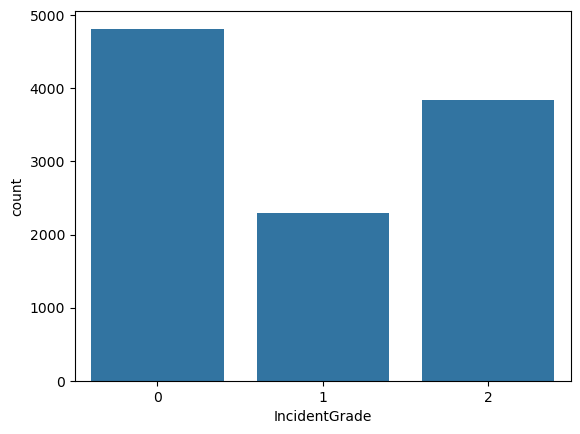

0    4815
2    3838
1    2294
Name: IncidentGrade, dtype: int64


In [1256]:
sns.countplot(x='IncidentGrade', data=df)
plt.show()

# Check the distribution of numerical features
df.describe()

# Checking for class imbalance in IncidentGrade
print(df['IncidentGrade'].value_counts())


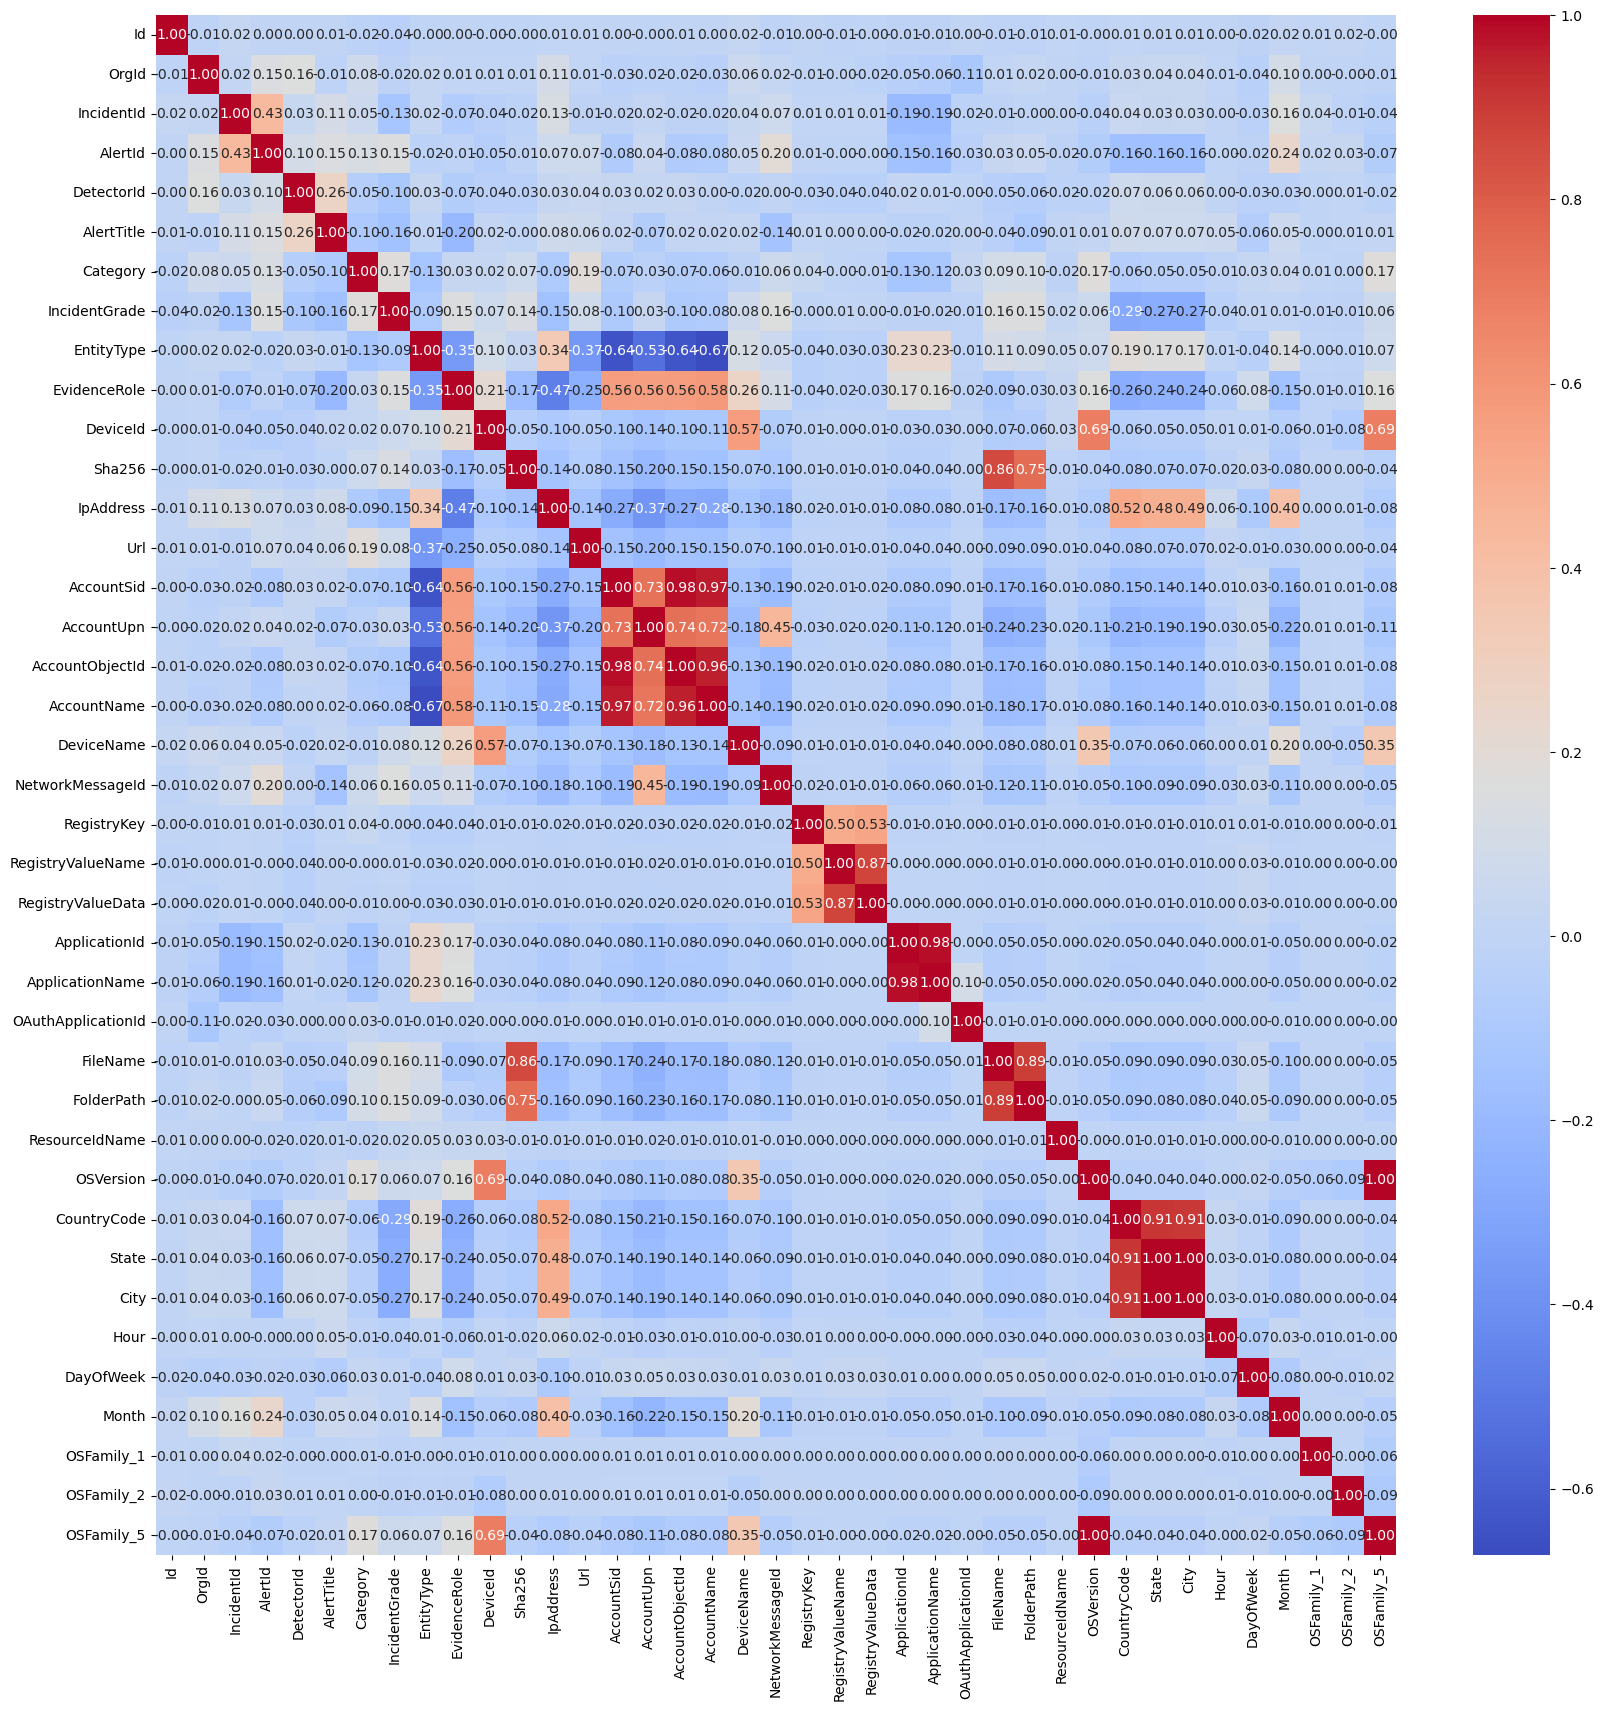

In [1252]:
# Correlation heatmap to check the relationship between features
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [1216]:
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [1230]:
# Logistic Reg


# Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = logreg.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))



Logistic Regression Accuracy: 0.5292237442922374
              precision    recall  f1-score   support

           0       0.52      0.75      0.62       963
           1       0.67      0.00      0.01       439
           2       0.54      0.56      0.55       788

    accuracy                           0.53      2190
   macro avg       0.58      0.44      0.39      2190
weighted avg       0.56      0.53      0.47      2190



In [1220]:
# XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_xgb = xgb_model.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:37:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8447488584474886
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       963
           1       0.83      0.72      0.77       439
           2       0.91      0.81      0.86       788

    accuracy                           0.84      2190
   macro avg       0.85      0.82      0.83      2190
weighted avg       0.85      0.84      0.84      2190



In [1222]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8210045662100457
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       963
           1       0.86      0.66      0.75       439
           2       0.90      0.78      0.83       788

    accuracy                           0.82      2190
   macro avg       0.84      0.79      0.81      2190
weighted avg       0.83      0.82      0.82      2190



In [1224]:
# Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_gb = gb_model.predict(X_test)
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.7767123287671233
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       963
           1       0.86      0.53      0.65       439
           2       0.89      0.71      0.79       788

    accuracy                           0.78      2190
   macro avg       0.82      0.73      0.75      2190
weighted avg       0.80      0.78      0.77      2190



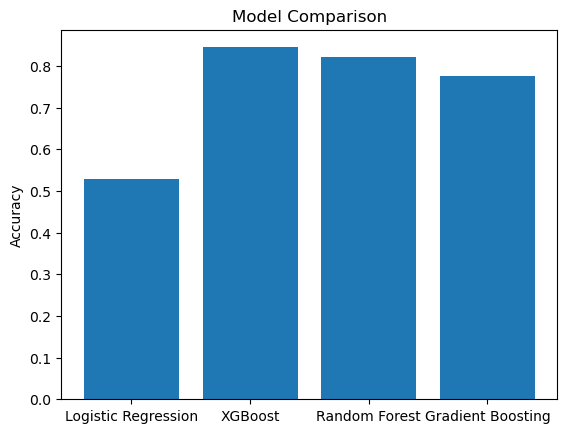

In [1226]:
# Compare model performance
models = ['Logistic Regression', 'XGBoost', 'Random Forest', 'Gradient Boosting']
accuracies = [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_gb)]

plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()


In [1232]:
df.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSVersion,CountryCode,State,City,Hour,DayOfWeek,Month,OSFamily_1,OSFamily_2,OSFamily_5
0,8589935897,44,19153,14081,50,36,7,0,10,0,98799,138268,360606,160396,441377,15140,425863,453297,771,192054,1631,635,860,2251,3421,881,289573,117668,3586,66,242,1445,10630,1,4,6,0,0,1
1,936302875112,135,20224,14666,1446,219,1,0,19,1,98799,138268,360606,42701,441377,673934,425863,453297,771,529644,1631,635,860,2251,3421,881,289573,117668,3586,66,242,1445,10630,14,1,6,0,0,1
2,1554778164218,55,33344,51030,1,1,10,2,11,0,98799,138268,360606,160396,31109,24740,31198,35577,771,529644,1631,635,860,2251,3421,881,289573,117668,3586,66,242,1445,10630,11,0,6,0,0,1
3,1571958033652,85,318386,290672,69,42615,7,0,8,0,98799,138268,360606,160396,441377,673934,425863,453297,456,529644,1631,635,860,2251,3421,881,289573,117668,3586,66,242,1445,10630,3,2,6,0,0,1
4,704374641744,1504,45056,362227,6,5,10,1,11,0,98799,138268,360606,160396,34037,36477,33297,34392,771,529644,1631,635,860,2251,3421,881,289573,117668,3586,66,242,1445,10630,19,5,6,0,0,1


In [1250]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Sample data preparation for demonstration (assuming df is already available)
# Encode the target variable 'IncidentGrade'
label_encoder = LabelEncoder()
df['IncidentGrade'] = label_encoder.fit_transform(df['IncidentGrade'])


# # Separate features (X) and target (y)
# X = df.drop(columns=['IncidentGrade'])
# y = df['IncidentGrade']

# # Handle categorical data by one-hot encoding
# X = pd.get_dummies(X, columns=['Category', 'EntityType', 'EvidenceRole', 'DeviceName'], drop_first=True)

# # Normalize numerical features
# numerical_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 'IpAddress', 
#                      'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'NetworkMessageId',
#                      'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
#                      'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSVersion', 'CountryCode', 
#                      'State', 'City']

# scaler = StandardScaler()
# X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Convert predicted classes back to original labels if needed
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)


Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.3729 - loss: 1493594880.0000 - val_accuracy: 0.4397 - val_loss: 923670720.0000
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.3778 - loss: 988845696.0000 - val_accuracy: 0.3607 - val_loss: 634602112.0000
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.3533 - loss: 405228032.0000 - val_accuracy: 0.2018 - val_loss: 465759712.0000
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.3439 - loss: 362365728.0000 - val_accuracy: 0.2009 - val_loss: 347610816.0000
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.3629 - loss: 348015616.0000 - val_accuracy: 0.3607 - val_loss: 264455392.0000
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.3470 - loss: 243241744.0000 - val_accuracy: 0.4388 - val_loss: 282780672.0000
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.3559 - loss: 254025728.0000 - val_accuracy: 0.4388 - val_los